# [WK] Projekt 1 - Opis obrazu
#### Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395), Daniel Zdancewicz (145317)

## Opis zadania
Śledzenie gry w bilard.
Dla filmów przedstawiających grę w bilard (dowolna odmiana) zaproponuj system:
- Wykrywania bili
- Śledzenia bili
- Wykrywania zdarzeń na filmie
Należy samodzielnie przygotować odpowiednie dane wejściowe.

## Założenia
Jako przyjętą reprezentację obrazu przyjęto filmy gry w snookera z perspektywy ptaka (bird view).
Założono, że kamera jest nieruchoma, a stół do gry jest prostokątem. DOdatkowo założono, że
kamera jest umieszczona nad środkiem stołu, a kąt nachylenia kamery jest równy 90 stopni.

Jako zdarzenia, które są wykrywane na filmie:
- Wbicie bili do łuzy
- Zderzenie bili z drugą bilą


## Technika wykrywania bil na obrazie

1. Wczytanie obrazu
2. Przekształcenie obrazu do skali szarości
3. ???
4. Rozpoznanie 7 masek (po jednej dla każdego koloru bili)
5. Rozpoznanie konturów bili
6. Zapis pozycji zawierających kontury w kolejnych klatkach filmu
7. Zastosowanie prostych równań fizycznych na podstawie pozycji do wyznaczenia pozycji bili w kolejnych klatkach filmu
8. Wykrywanie zdarzeń na podstawie momentum kuli


# Importy

In [292]:
import matplotlib
import PIL
from cv2 import VideoCapture, CAP_PROP_FPS
import cv2
from typing import Iterable
import numpy as np
from numpy import uint8 as u8, int8 as i8
from numpy.typing import NDArray
from dataclasses import dataclass, field
from random import choice

from skimage.morphology import disk

## Wczytanie filmu

In [293]:
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow

  imshow = cv2_imshow
else:
  def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
      if a.shape[2] == 4:
        a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
      else:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

In [294]:
from copy import deepcopy


@dataclass
class VideoInfo(object):
  fps: float
  width: int
  height: int
  dtype: type
  frames: list[NDArray[u8]] = field(default_factory=list)

  def __len__(self):
    return len(self.frames)

  @classmethod
  def from_video(cls, video: VideoCapture):
    width = int(video.get(3))
    height = int(video.get(4))
    fps = video.get(CAP_PROP_FPS)
    frames = []
    while True:
      success, frame = video.read()
      if not success: break
      frames.append(frame)
    dtype = len(frames) > 0 and frames[0].dtype or None
    return cls(fps, width, height, dtype, frames)

  def sample(self):
    return deepcopy(choice(self.frames))


In [295]:
match = VideoCapture('resources/matches/match-1-topdown-view.mp4')

video = VideoInfo.from_video(match)

## Prezentacja parametrów filmu


Video info:
  FPS    : 25.0
  Width  : 1280
  Height : 720
  Frame  : 3245
  d-type : uint8



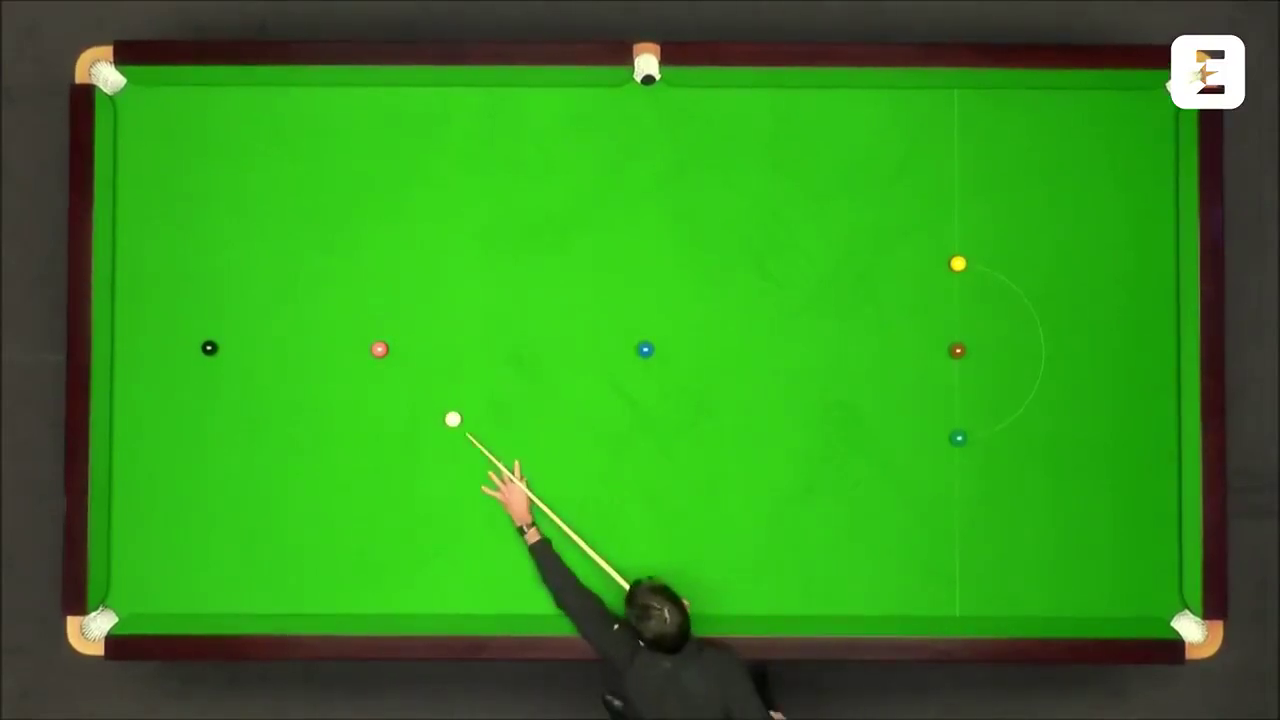

In [296]:
print(f"""
Video info:
  FPS    : {video.fps}
  Width  : {video.width}
  Height : {video.height}
  Frame  : {len(video)}
  d-type : {video.dtype}
""")

imshow(video.sample())

## Wykrywanie krawędzi stołu

In [297]:
def fft(image: NDArray[u8], size: Iterable[int] | None = None) -> tuple[NDArray[u8], int]:
  frequencies = np.fft.fft2(image, size)
  shift = np.fft.fftshift(frequencies)
  spectrum = 20 * np.log(np.abs(shift))
  return shift, spectrum


def ifft(shift: NDArray[u8]) -> NDArray[u8]:
  inverse = np.fft.ifftshift(shift)
  image = np.fft.ifft2(inverse)
  return np.real(image)


In [298]:
class Kernel(object):
  @staticmethod
  def sobel_horizontal() -> NDArray[u8]:
    return np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=i8)

  @staticmethod
  def sobel_vertical() -> NDArray[u8]:
    return np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=i8)


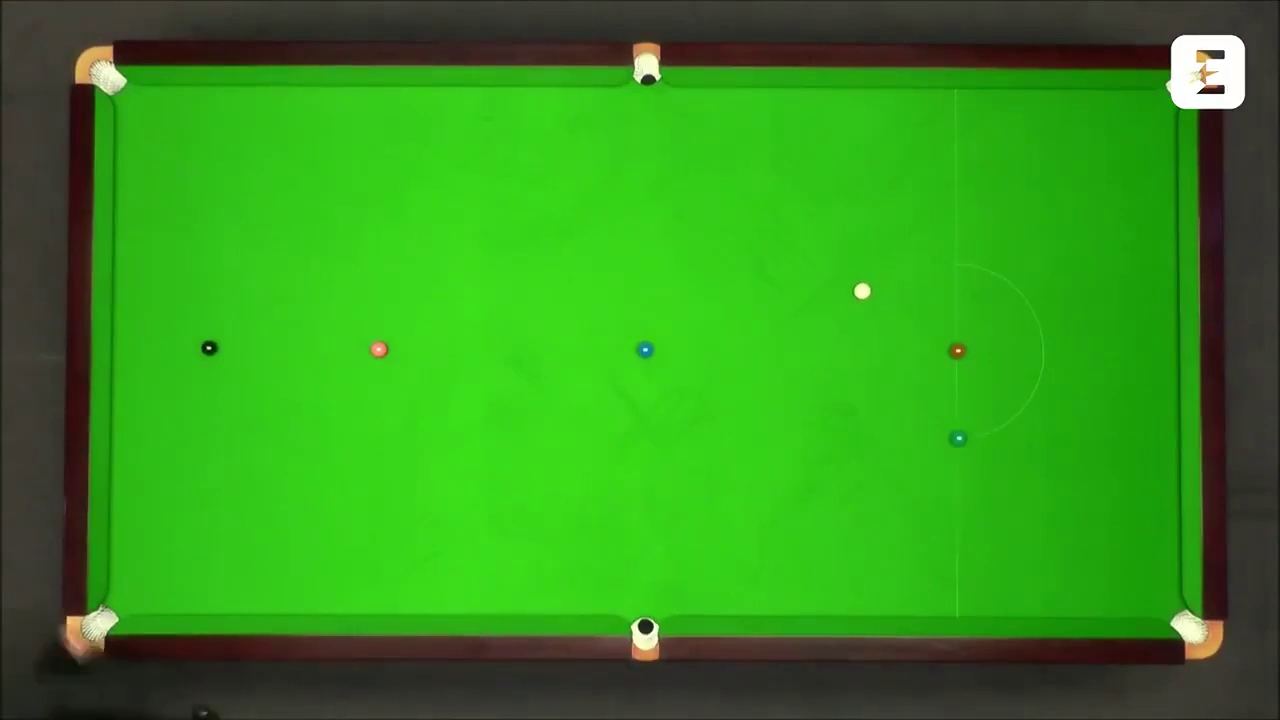

In [299]:
image = video.sample()

imshow(image)

In [300]:
class DrawContext(object):
  def __init__(self, image: NDArray[u8], coordinates: Iterable[tuple[int, int, int]] = None):
    self.image = image.copy()
    self.coordinates = coordinates
    if self.coordinates is None: self.coordinates = []

  def points(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, _) in coordinates:
      cv2.circle(self.image, (x, y), 4, (255, 0, 0), -1)
    return self

  def boxes(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, z) in coordinates:
      cv2.rectangle(self.image, (x - 16, y - 16), (x + 16, y + 16), (255, 0, 0), 2)
    return self

  def discs(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, z) in coordinates:
      cv2.circle(self.image, (x, y), z, (0, 0, 255), -1)
    return self

  def use(self, coordinates: Iterable[tuple[int, int, int]]):
    self.coordinates = coordinates
    return self

  def consume(self):
    return self.image

In [301]:
class TransformContext(object):
  def __init__(self, image: NDArray[u8]):
    self.image = image.copy()

  def grayscale(self):
    self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    return self

  def threshold(self, under: int | None = None, over: int | None = None):
    if under is not None: self.image[self.image < under] = 0
    if over is not None: self.image[self.image > over] = 0
    return self

  def clip_edges(self, size: int):
    self.image[:size, :] = 0
    self.image[-size:, :] = 0
    self.image[:, :size] = 0
    self.image[:, -size:] = 0
    return self

  def dilate(self, kernel: NDArray[u8], iterations: int = 1):
    self.image = cv2.dilate(self.image, kernel, iterations=iterations)
    return self

  def erode(self, kernel: NDArray[u8], iterations: int = 1):
    self.image = cv2.erode(self.image, kernel, iterations=iterations)
    return self

  def opening(self, kernel: NDArray[u8], iterations: int = 1):
    self.image = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return self
  def closing(self, kernel: NDArray[u8], iterations: int = 1):
    self.image = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return self

  def proper_opening(self, kernel: NDArray[u8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    self.image = np.maximum(self.image, intermediate)
    return self

  def proper_closing(self, kernel: NDArray[u8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    self.image = np.minimum(self.image, intermediate)
    return self

  def automedian(self, kernel: NDArray[u8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    self.image = np.maximum(intermediate, self.proper_closing(kernel).consume())
    return self

  def consume(self):
    return self.image.copy()

/tmp/ipykernel_180374/15401090.py:4: RuntimeWarning: divide by zero encountered in log
  spectrum = 20 * np.log(np.abs(shift))


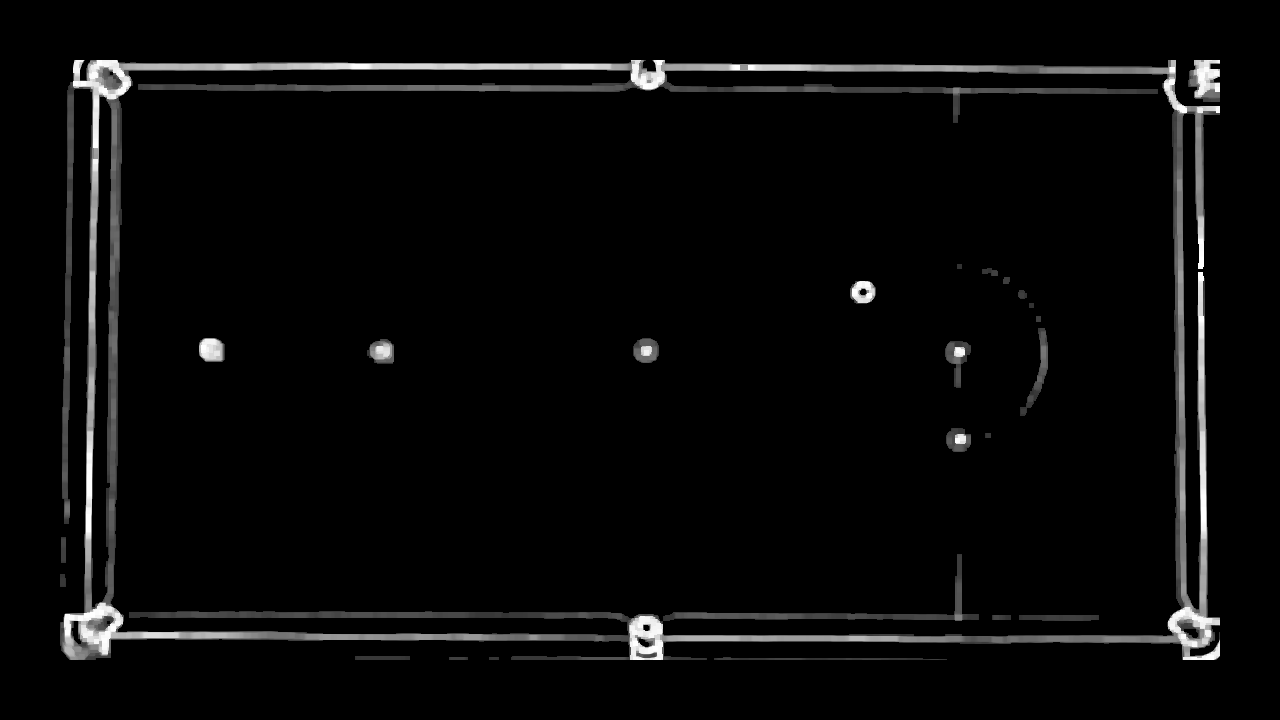

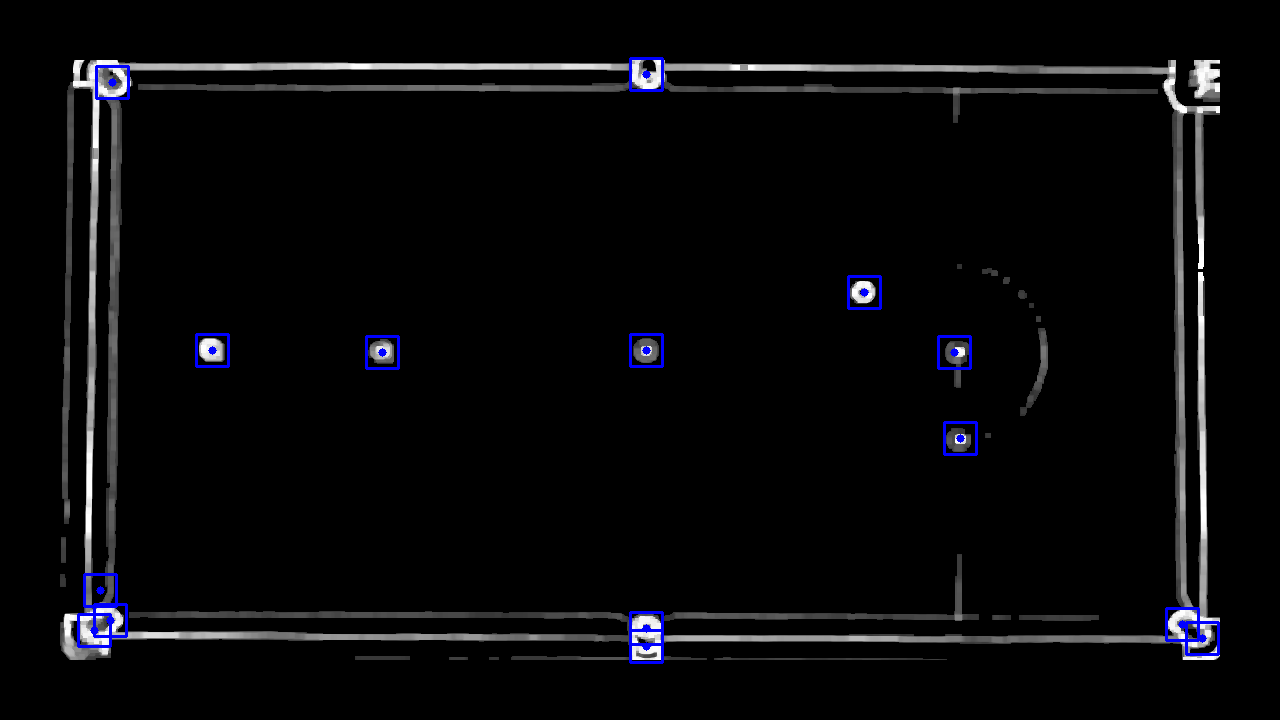

In [303]:
def magnify_objects(image: NDArray[u8]) -> NDArray[u8]:
  grayscale = TransformContext(image).grayscale().consume()
  vertical_kernel = Kernel.sobel_vertical()
  horizontal_kernel = Kernel.sobel_horizontal()

  shift, _ = fft(grayscale)
  vertical_shift, _ = fft(vertical_kernel, image.shape[:2])
  horizontal_shift, _ = fft(horizontal_kernel, image.shape[:2])

  vertical = ifft(shift * vertical_shift)
  horizontal = ifft(shift * horizontal_shift)

  return (TransformContext(np.sqrt(vertical ** 2 + horizontal ** 2).astype(u8))
          .dilate(np.ones((3, 3)), 2)
          .threshold(50)
          .proper_opening(np.ones((16, 16)))
          .automedian(np.ones((3, 3)))
          .clip_edges(60)
          .consume())

def find_discs(image: NDArray[u8]) -> NDArray[tuple[int, int, int]]:
  coordinates = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 15, param1=500, param2=10, minRadius=8, maxRadius=16)
  if not len(coordinates): coordinates = np.array([[]])
  return np.uint16(np.around(coordinates))[0]


magnified = magnify_objects(image)
imshow(magnified)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cimg = cv2.cvtColor(magnified, cv2.COLOR_GRAY2BGR)
coordinates = find_discs(magnified)
circled_image = DrawContext(cimg, coordinates).boxes().points().consume()
imshow(circled_image)